# Parameter Settings

In [1]:
import json
import pandas as pd
import numpy as np
import math

from datetime import datetime
from random import sample 

In [2]:
!pip install inequality

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, IntegerType

In [4]:
# Parameter settings
location = "boston"
#location = "geneva"

In [6]:
%r
install.packages("ineq")
install.packages("gglorenz")
# install.packages("plotly")
library(gglorenz)
library(ineq)
library(SparkR)
library(data.table)
library(ggplot2)
# library(plotly)
options(repr.plot.width=400, repr.plot.height=400)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-6-364adecc99af>, line 11)

# Load Listings from Historical Index

In [8]:
# ElasticSeach
from elasticsearch import Elasticsearch
es = Elasticsearch()

In [9]:
from elasticsearch.helpers import scan

# Query parameters
index_name = "airbnb_history_" + location

res = scan(
    es,
    index=index_name,
    query={"query": { "match_all" : {}}}
)

In [10]:
data = list(res)
len(data)

162737

In [11]:
# appending rows 
docs = []
for item in data:  
    doc = {
        'id': item['_id'],
        'index': item['_index'],
        'listing_url': item['_source']['listing_url'],
        'scrape_id': item['_source']['scrape_id'],
        'last_scraped': item['_source']['last_scraped'],
        'crawled_date': item['_source']['crawled_date'],
        'name': item['_source']['name'],
        'host_id': item['_source']['host_id'],
        'host_is_superhost': item['_source']['host_is_superhost'],
        'host_identity_verified': item['_source']['host_identity_verified'],
        'room_type': item['_source']['room_type'],
        'accommodates': item['_source']['accommodates'],
        'guests_included': item['_source']['guests_included'],
        'minimum_nights': item['_source']['minimum_nights'],
        'maximum_nights': item['_source']['maximum_nights'],
        'calendar_updated': item['_source']['calendar_updated'],
        'instant_bookable': item['_source']['instant_bookable'],
        'is_business_travel_ready': item['_source']['is_business_travel_ready'],
        'cancellation_policy': item['_source']['cancellation_policy'],
        'price': item['_source']['price'],
        'availability_30': item['_source']['availability_30'],
        'availability_60': item['_source']['availability_60'],
        'availability_90': item['_source']['availability_90'],
        'availability_365': item['_source']['availability_365'],
        'first_review': item['_source']['first_review'],
        'last_review': item['_source']['last_review'],
        'review_scores_rating': item['_source']['review_scores_rating'],
        'review_scores_accuracy': item['_source']['review_scores_accuracy'],
        'review_scores_cleanliness': item['_source']['review_scores_cleanliness'],
        'review_scores_checkin': item['_source']['review_scores_checkin'],
        'review_scores_communication': item['_source']['review_scores_communication'],
        'review_scores_location': item['_source']['review_scores_location'],
        'review_scores_value': item['_source']['review_scores_value'],
        'overall_rating': item['_source']['overall_rating']
    }
    
    docs.append(doc) 

In [12]:
df = pd.DataFrame(docs)

In [13]:
date_snapshots = np.sort(df.crawled_date.unique())

date_snapshots

array(['20151002', '20160906', '20171005', '20180414', '20180517',
       '20180718', '20180817', '20180914', '20181011', '20181117',
       '20181213', '20190117', '20190209', '20190312', '20190415',
       '20190519', '20190614', '20190714', '20190819', '20190922',
       '20191018', '20191121', '20191204', '20200105', '20200213',
       '20200316', '20200414', '20200512', '20200610', '20200711',
       '20200831', '20200928', '20201024'], dtype=object)

In [14]:
doc_dist = df['crawled_date'].value_counts().sort_index(ascending=True)

doc_dist

20151002    2558
20160906    3585
20171005    4870
20180414    6393
20180517    5968
20180718    5997
20180817    6036
20180914    5957
20181011    6014
20181117    6296
20181213    6217
20190117    6247
20190209    6155
20190312    6221
20190415    6202
20190519    6241
20190614    6246
20190714    6264
20190819    6214
20190922    5711
20191018    5647
20191121    5387
20191204    3507
20200105    3746
20200213    3903
20200316    3799
20200414    3845
20200512    3688
20200610    3440
20200711     497
20200831    3339
20200928    3293
20201024    3254
Name: crawled_date, dtype: int64

In [15]:
df.to_csv(location + "_historical_listing.csv")

# Load Historical Listings from File

In [16]:
listings = spark.read.option("header",True).csv(location + "_historical_listing.csv").filter((col("crawled_date") >= "20190601") & (col("crawled_date") < "20200701"))

listings = listings.withColumn("month", concat(col("crawled_date").substr(1, 4), lit("-"), col("crawled_date").substr(5, 2), lit("-01")))
listings.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- id: string (nullable = true)
 |-- index: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- crawled_date: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: string (nullable = true)
 |-- guests_included: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- maximum_nights: string (nullable = true)
 |-- calendar_updated: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- is_business_travel_ready: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- price: string (nullable = true)
 |-- availability_30: string (nullable = true)
 |-- availability_60: string

In [17]:
available_listings = listings.withColumn("availability", when(col("availability_30") > 0, 1).otherwise(0)).groupBy("month").agg(count("listing_url").alias("num_listings"), sum("availability").alias("available_listings")).orderBy("month")
available_listings.show()

+----------+------------+------------------+
|     month|num_listings|available_listings|
+----------+------------+------------------+
|2019-06-01|        6246|              4191|
|2019-07-01|        6264|              4042|
|2019-08-01|        6214|              3914|
|2019-09-01|        5711|              3395|
|2019-10-01|        5647|              3455|
|2019-11-01|        5387|              3416|
|2019-12-01|        3507|              2492|
|2020-01-01|        3746|              2560|
|2020-02-01|        3903|              2789|
|2020-03-01|        3799|              2770|
|2020-04-01|        3845|              2668|
|2020-05-01|        3688|              2561|
|2020-06-01|        3440|              2281|
+----------+------------+------------------+



In [18]:
listings_pd = available_listings.toPandas()

In [19]:
listings_pd

,month,num_listings,available_listings
0,2019-06-01,6246,4191
1,2019-07-01,6264,4042
2,2019-08-01,6214,3914
3,2019-09-01,5711,3395
4,2019-10-01,5647,3455
5,2019-11-01,5387,3416
6,2019-12-01,3507,2492
7,2020-01-01,3746,2560
8,2020-02-01,3903,2789
9,2020-03-01,3799,2770


In [20]:
import matplotlib.pyplot as plt 

In [21]:
listings_pd.dtypes

month                 object
num_listings           int64
available_listings     int64
dtype: object

In [22]:
listings_pd["month"] = pd.to_datetime(listings_pd["month"])
print(listings_pd)

        month  num_listings  available_listings
0  2019-06-01          6246                4191
1  2019-07-01          6264                4042
2  2019-08-01          6214                3914
3  2019-09-01          5711                3395
4  2019-10-01          5647                3455
5  2019-11-01          5387                3416
6  2019-12-01          3507                2492
7  2020-01-01          3746                2560
8  2020-02-01          3903                2789
9  2020-03-01          3799                2770
10 2020-04-01          3845                2668
11 2020-05-01          3688                2561
12 2020-06-01          3440                2281


In [23]:
listings_pd = listings_pd.set_index("month")

<AxesSubplot:xlabel='month'>

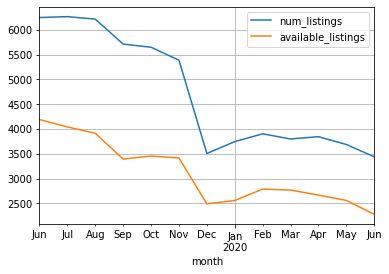

In [24]:
listings_pd.plot(grid=True)

# Load Search Impression

In [25]:
index_name = "airbnb-history-" + location

In [33]:
impressions = spark.read.option("header",True).csv(index_name + '-impressions.csv').withColumn("month", concat(col("filter_crawled_date").substr(1, 4), lit("-"), col("filter_crawled_date").substr(5, 2), lit("-01")))
impressions.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- query: string (nullable = true)
 |-- filter_crawled_date: string (nullable = true)
 |-- filter_host_is_superhost: string (nullable = true)
 |-- filter_instant_bookable: string (nullable = true)
 |-- filter_room_type: string (nullable = true)
 |-- filter_minimum_nights: string (nullable = true)
 |-- filter_availability_30: string (nullable = true)
 |-- filter_accommodates: string (nullable = true)
 |-- filter_maximum_nights: string (nullable = true)
 |-- search_id: string (nullable = true)
 |-- paginated_id: string (nullable = true)
 |-- total_pages: string (nullable = true)
 |-- total_results: string (nullable = true)
 |-- result_size: string (nullable = true)
 |-- position: string (nullable = true)
 |-- score: string (nullable = true)
 |-- doc_id: string (nullable = true)
 |-- index: string (nullable = true)
 |-- title: string (nullable = true)
 |-- availability_30: string (nullable = true)
 |-- list

In [29]:
impressions.count()

114625

In [34]:
impressions_per_month = impressions.groupBy("month").agg(countDistinct("search_id").alias("num_searches"), count("doc_id").alias("num_impressions")).orderBy("month")


In [35]:
impressions_per_month.show()

+----------+------------+---------------+
|     month|num_searches|num_impressions|
+----------+------------+---------------+
|2019-07-01|        2020|          33888|
|2019-08-01|        1932|          33148|
|2019-09-01|        1786|          30638|
|2019-10-01|        1054|          16951|
+----------+------------+---------------+



In [36]:
impressions.select("filter_crawled_date").distinct().show()

+-------------------+
|filter_crawled_date|
+-------------------+
|           20191018|
|           20190714|
|           20190819|
|           20190922|
+-------------------+

